## Downloading and Extracting the data

In [992]:
!wget -O samples.zip --no-check-certificate "https://drive.google.com/uc?export=download&id=1c4N148sKsODpsqhCSrbI5NZNt4q4KVS8" 

--2022-09-11 05:24:01--  https://drive.google.com/uc?export=download&id=1c4N148sKsODpsqhCSrbI5NZNt4q4KVS8
Resolving drive.google.com (drive.google.com)... 173.194.193.138, 173.194.193.139, 173.194.193.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.193.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qv4j9o12lbitstic480p85425i2oe8qe/1662873825000/01242425839236815817/*/1c4N148sKsODpsqhCSrbI5NZNt4q4KVS8?e=download&uuid=dd622e82-afa5-4085-a997-8e1336e2b153 [following]
--2022-09-11 05:24:05--  https://doc-0c-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qv4j9o12lbitstic480p85425i2oe8qe/1662873825000/01242425839236815817/*/1c4N148sKsODpsqhCSrbI5NZNt4q4KVS8?e=download&uuid=dd622e82-afa5-4085-a997-8e1336e2b153
Resolving doc-0c-ao-docs.googleusercontent.com (doc-0c-ao-docs.googleusercontent.com)... 142.250.1.132, 26

In [993]:
!rm -r samples
!rm -r __MACOSX
!unzip -q samples.zip

## Setting seeds to get reproducable results

In [994]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Inspecting the data

lets get a list of all images:

In [995]:
import os
captchas = os.listdir('samples')
captchas[:5]

['g6n7x.png', 'ycmcw.png', '6mn8n.png', 'mfc35.png', 'wbncw.png']

we can check what characters are used in captchas:

In [996]:
chars = set()

for name in captchas:
  captcha = name.split('.')[0]
  for char in captcha:
    chars.add(char)

chars = list(chars)
chars.sort()
for char in chars:
  print(char, end=' ')

print('\nNumber of characters:', len(chars))

2 3 4 5 6 7 8 b c d e f g m n p w x y 
Number of characters: 19


we should add the name of the folder before images name:

In [997]:
file_names = list(map(lambda f: f'samples/{f}', captchas))

now lets view an image to check if everything is well:


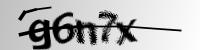

In [998]:
from IPython.display import Image
Image(file_names[0])

## Preprocessing and creating the dataset


Firstly, we need a function to create our labels using the file name:

notice that each label is a 1.5.19 matrix:

In [999]:
import numpy as np
import tensorflow as tf
from typing import List

def create_label_matrix(captcha_value: str, chars: np.array) -> List[np.array]:
  '''
  Creates a numpy array with size 1 * len(captcha_velue) * len(chars) containing one-hot encoded values
  of the captcha_value characters with respecto chars.
  :param captcha_value tf.Tensor: a string containg correct answer for a capctha as a tensor
  :param chars np.array: a numpy array containing all characters used in captchas
  :return a numpy array with size 1 * len(captcha_velue) * len(chars) containing one-hot encoded values
  '''
  length = len(captcha_value)
  digits = []
  for i in range(length):
    digits.append((chars == captcha_value[i]).astype(int))
  return digits

now we can write a function to preprocess an image:

In [1000]:
import tensorflow.io as tfio
import tensorflow.image as tfim

def preprocess(image_path: tf.Tensor, image_size = (0, 0)) -> tf.Tensor:
  '''
  A function to preprocess an image.
  :param image_path tf.Tensor: path of the image stored in a tensor
  :param image_size int: output image size if reshaping is needed. by default it will not reshape the image.
  :return The tensor of the normalized image.
  '''
  # read image file
  image = tfio.read_file(image_path)
  # decode the image into 3 channels
  image = tfim.decode_jpeg(image, channels = 3)
  # black and white
  image = tfim.rgb_to_grayscale(image)
  # normalize the image
  image = tfim.convert_image_dtype(image, np.float32)
  # reshape the image if needed
  if image_size is not None:
    image = tfim.resize(image, size = image_size)
  return image

we need a function to get a file name and returns the image tensor and its label.

In [1001]:
from typing import Tuple

def create_xy_tuple(filename: tf.Tensor, label: tf.Tensor, chars: np.array, image_size = None) -> Tuple[tf.Tensor, np.array]:
  '''
  Given the file name creates a tuple containg the tensor of the image and a numpy array for its label.
  :param filename str: name of the image file
  :param label str: label of the image
  :param chars np.array: a numpy array of all expected characters
  :return a tuple containg the preprocessed image tensor and a numpy array of its label.
  '''
  image = preprocess(filename, image_size = image_size)
  label_array = create_label_matrix(label, chars)
  return image, label_array

now we can create our datasets:

In [1002]:
import tensorflow.data as tfd
from typing import List
import math

def create_datasets(file_names: List[str], labels: List[str], chars: np.array, shuffle: bool = True,
                    test_size: float = 0.1, val_size: float = 0.1, image_size: Tuple[int,int] = None):
  '''
    A function to create train, validation and test datasets.
    :param file_names List[str]: a list of strings containing file names
    :param labels List[str]: a list of strings containing labels
    :param chars np.array: a numpy array containing all characters used in captchas
    :param shuffle bool: if the dataset should be shuffled or not
    :param test_size float: the size of the test dataset
    :param val_size float: the size of the validation dataset
    :param image_size Tuple[int,int]: the size of the images
    :return train, validation and test datasets
  '''
  # creating the labels
  new_labels = [[] for i in range(5)]
  for l in labels:
    labels = create_label_matrix(l, chars)
    for i in range(5):
      new_labels[i].append(labels[i])
  # create the dataset
  data = (file_names, ) + tuple(new_labels)
  dataset = tfd.Dataset.from_tensor_slices(data)
  # shuffle if needed
  if shuffle:
    dataset = dataset.shuffle(buffer_size = len(file_names), reshuffle_each_iteration = False)
  # load images and preprocess
  dataset = dataset.map(lambda filename, l0, l1, l2, l3, l4: (preprocess(filename, image_size = image_size), l0, l1, l2, l3, l4))
  # create training, validation and test dataset
  train_size = math.floor(len(file_names) * (1 - val_size - test_size))
  val_size = math.floor(len(file_names) * val_size)
  train_dataset = dataset.take(train_size)
  val_dataset = dataset.take(train_size + val_size).skip(train_size)
  test_dataset = dataset.skip(train_size + val_size)
  return train_dataset, val_dataset, test_dataset

IMAGE_SIZE = (50, 200)
chars = np.array(chars)
captchas = list(map(lambda c: c.split('.')[0], captchas)) # remove extenstion from file names
train_data, val_data, test_data = create_datasets(file_names, captchas, chars, image_size = IMAGE_SIZE)

we can check if the dimensions are correct:

In [1003]:
print(train_data.element_spec, len(train_data))
print(val_data.element_spec, len(val_data))
print(test_data.element_spec, len(test_data))

(TensorSpec(shape=(50, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None)) 856
(TensorSpec(shape=(50, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None)) 107
(TensorSpec(shape=(50, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None)) 107


and we can view an image to ensure that the preprocessing step is done:

tf.Tensor([0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0], shape=(19,), dtype=int64) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(19,), dtype=int64) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0], shape=(19,), dtype=int64) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0], shape=(19,), dtype=int64) tf.Tensor([0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0], shape=(19,), dtype=int64)


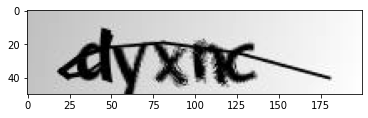

In [1004]:
import matplotlib.pyplot as plt

for image, l0, l1, l2, l3, l4 in train_data.take(1):
  plt.imshow(image.numpy().reshape(IMAGE_SIZE[0], IMAGE_SIZE[1]), cmap = 'gray')
  print(l0, l1, l2, l3, l4)

we need a function to general te batches:

In [1005]:
def generate_batch(dataset: tfd.Dataset, batch_size : int = 32, shuffle = True, shuffle_buffer_size = 10):
  '''
    A function to generate batches from a dataset.
    :param dataset tfd.Dataset: a dataset to generate batches from
    :param batch_size int: the size of the batch
    :param shuffle bool: if the dataset should be shuffled or not
    :param shuffle_buffer_size int: the size of the buffer used to shuffle the dataset
    :return a batch from the dataset
  '''
  images, l0s, l1s, l2s, l3s, l4s = [], [], [], [], [], []
  while True:
    if shuffle:
      dataset = dataset.shuffle(buffer_size = shuffle_buffer_size)
    for img, l0, l1, l2, l3, l4 in dataset:
      images.append(img)
      l0s.append(l0)
      l1s.append(l1)
      l2s.append(l2)
      l3s.append(l3)
      l4s.append(l4)
      if len(images) == batch_size:
        yield np.array(images), [np.array(l0s), np.array(l1s), np.array(l2s), np.array(l3s), np.array(l4s)]
        images, l0s, l1s, l2s, l3s, l4s = [], [], [], [], [], []


Now that we've finished our data processing, its time to create our model.

## Building the model

We can use keras functional API to create our model. The model architecture is as follows:

INPUT 50×200×1

8 CONV 3×3 SAME -> 50×200×8  
BATCH NORM -> 50×200×8  
MAX POOL 2×2 -> 25×100×8  
Dropout(0.1)

16 CONV 3×3 SAME -> 25×100×16  
BATCH NORM -> 25×100×16  
MAX POOL 2×2 -> 13×50×16  
Dropout(0.1)

32 CONV 3×3 SAME -> 13×50×32  
BATCH NORM -> 13×50×32  
MAX POOL 2×2 -> 7×25×32
Dropout(0.1)

64 CONV 3×3 SAME -> 13×50×64  
BATCH NORM -> 13×50×64  
MAX POOL 2×2 -> 7×25×64
Dropout(0.1)

FLATTEN (3328) -> 5 branches:  
1.Dense(128) -> Dropout(0.5) -> Dense(19)  
2.Dense(128) -> Dropout(0.5) -> Dense(19)  
3.Dense(128) -> Dropout(0.5) -> Dense(19)  
4.Dense(128) -> Dropout(0.5) -> Dense(19)  
5.Dense(128) -> Dropout(0.5) -> Dense(19)

so, lets create a layer to represent a package containing a CONV, a batch norm layer and a POOL layer:

In [1006]:
from tensorflow.keras import layers
import tensorflow.keras as tfk

class ConvPoolBlock(layers.Layer):
  '''
    A layer that performs a convolution, batch normalization, max pooling, and dropout. \n
    CONV -> BN -> RELU -> MAXPOOL -> DROPOUT
  '''

  def __init__(self, conv_filters, conv_kernel = (3,3), conv_stride = (1,1), conv_padding = 'same',activation = 'relu',
               pool = True, max_pool_kernel = (2,2), pool_stride = None, pool_padding = 'same', batch_norm = True , dropout = True, dropout_rate = 0.2):
    '''
        Creates a layer that performs a convolution, batch normalization, max pooling, and dropout.
        :param conv_filters int: number of filters in the convolutional layer 
        :param conv_kernel Tuple[int, int]: kernel size of the convolutional layer. default (3,3)
        :param conv_stride Tuple[int, int]: stride of the convolutional layer. default (1,1)
        :param conv_padding str: padding of the convolutional layer. default 'same'
        :param activation str: activation function of the convolutional layer. default 'relu'
        :param pool bool: whether to use max pooling or not. default True
        :param max_pool_kernel Tuple[int, int]: kernel size of the max pooling layer. default (2,2)
        :param pool_stride Tuple[int, int]: stride of the max pooling layer. default None
        :param pool_padding str: padding of the max pooling layer. default 'same'
        :param batch_norm bool: whether to use batch normalization or not. default True
        :param dropout bool: whether to use dropout or not. default True
        :param dropout_rate float: dropout rate. default 0.2
    '''
    super(ConvPoolBlock, self).__init__()
    self.conv = tfk.layers.Conv2D(conv_filters, conv_kernel, strides = conv_stride, padding = conv_padding, activation = activation)
    self.bn = tfk.layers.BatchNormalization()
    self.max_pool = tfk.layers.MaxPool2D(max_pool_kernel, strides = pool_stride, padding = pool_padding)
    self.dropout = tfk.layers.Dropout(rate = dropout_rate)
    self.has_batch_norm = batch_norm
    self.has_pool = pool
    self.has_dropout = dropout

  def call(self, x, training = False):
    '''Performs a convolution, batch normalization, max pooling, and dropout.'''
    x = self.conv(x, training = training)
    if self.has_batch_norm:
      x = self.bn(x, training = training)
    if self.has_pool:
      x = self.max_pool(x, training = training)
    if self.has_dropout and training:
      x = self.dropout(x)
    return x


Now we can create our dense blocks for each branch:

In [1007]:
class FCBlock(layers.Layer):
  '''
    A layer with 2 fully connected layers and a dropout layer between them. \n
    Dense -> Dropout -> Dense
  '''

  def __init__(self, out_name: str, first_layer = True, first_layer_units = 64, output_units = 19, dropout = True, dropout_rate = 0.5, hidden_activation = 'relu', output_activation='softmax'):
    '''
        Creates a layer with 2 fully connected layers and a dropout layer between them.
        :param out_name str: name of the output layer
        :param first_layer bool: whether this is the first layer or not. default True
        :param first_layer_units int: number of units in the first layer. default 64
        :param output_units int: number of units in the output layer. default 19
        :param dropout bool: whether to use dropout or not. default True
        :param dropout_rate float: dropout rate. default 0.5
        :param hidden_activation str: activation function of the hidden layer. default 'relu'
        :param output_activation str: activation function of the output layer. default 'softmax'
    '''
    super(FCBlock, self).__init__()
    self.dense1 = tfk.layers.Dense(first_layer_units, activation = hidden_activation) if first_layer else None
    self.dropout = tfk.layers.Dropout(dropout_rate) if dropout else None
    self.dense2 = tfk.layers.Dense(output_units, activation = output_activation)
    self._name = out_name
    self.first_layer = first_layer
    self.has_dropout = dropout

  def call(self, x, training = False):
    '''Performs a fully connected layer, a dropout layer, and another fully connected layer.'''
    if self.first_layer:
      x = self.dense1(x, training = training)
    if training and self.has_dropout:
      x = self.dropout(x)
    x = self.dense2(x, training = training)
    return x

finally, we can create a class for our model:

In [1008]:
class SimpleModelBuilder:
  '''
    A simple model with 4 convolutional layers and 5 branches with 2 fully connected layers each. \n
    8 CONV 3*3 -> 16 CONV 3*3 -> 32 CONV 3*3 -> 64 CONV 3*3 \n
    A dropout layer is added after each convolutional layer. \n
    5 branches: \n
    128 Dense -> 19 Dense \n
    128 Dense -> 19 Dense \n
    128 Dense -> 19 Dense \n
    128 Dense -> 19 Dense \n
    128 Dense -> 19 Dense \n
  '''
  def __init__(self) -> None:
      '''
      Creates a simple model with 4 convolutional layers and 5 branches with 2 fully connected layers each.
      '''
      # create the convolutional layers
      self.conv_pool1 = ConvPoolBlock(conv_filters = 8, dropout=True, dropout_rate = 0.1)
      self.conv_pool2 = ConvPoolBlock(conv_filters = 16, dropout=True, dropout_rate = 0.1)
      self.conv_pool3 = ConvPoolBlock(conv_filters = 32, dropout=True, dropout_rate = 0.1)
      self.conv_pool4 = ConvPoolBlock(conv_filters = 64, dropout=True, dropout_rate = 0.1)
      # create the flatten layer
      self.flatten_layer = tfk.layers.Flatten()
      # create the branches
      self.branches = [FCBlock(f'out{i}', first_layer_units=128) for i in range(5)]
      self.outputs = []
  
  def get_model(self, input_shape: Tuple[int, int, int] = (50, 200, 1)) -> tfk.Model:
      '''
      Creates a simple model with 4 convolutional layers and 5 branches with 2 fully connected layers each.
      :param input_shape Tuple[int, int, int]: shape of the input. default (50, 200, 1)
      :return tfk.Model: the model
      '''
      inputs = tfk.Input(shape=input_shape)  
      x = self.conv_pool1(inputs)
      x = self.conv_pool2(x)
      x = self.conv_pool3(x)
      x = self.conv_pool4(x)
      x = self.flatten_layer(x)
      for branch in self.branches:
          self.outputs.append(branch(x))
      return tfk.Model(inputs = inputs, outputs = self.outputs, name = 'model')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_75 (InputLayer)          [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv_pool_block_112 (ConvPoolB  (None, 25, 100, 8)  112         ['input_75[0][0]']               
 lock)                                                                                            
                                                                                                  
 conv_pool_block_113 (ConvPoolB  (None, 13, 50, 16)  1232        ['conv_pool_block_112[0][0]']    
 lock)                                                                                        

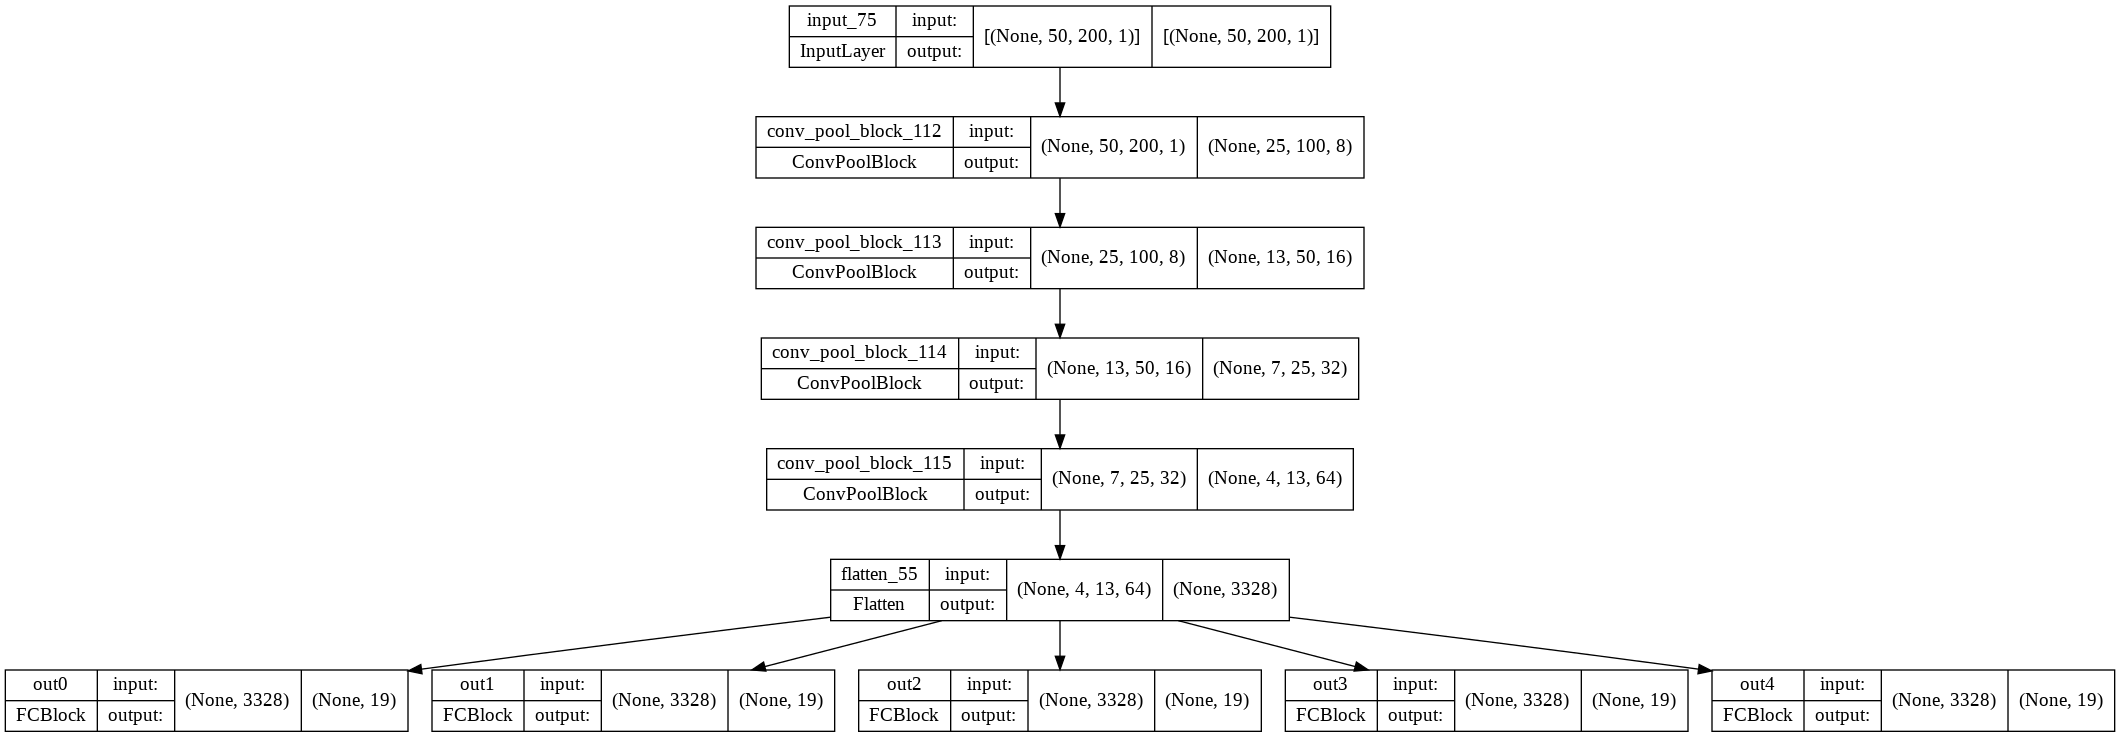

In [1009]:
builder = SimpleModelBuilder()
model = builder.get_model(input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model.summary()
tfk.utils.plot_model(model, 'simple-model.png', show_shapes=True)

before fitting the model, we can create our adaptive scheduler callback:

In [1010]:
import math

class AdaptiveSchedulerCallback(tfk.callbacks.Callback):
  """An adaptive learning rate scheduler in which the learning rate increases/decreases with respect to training loss.
  if the loss gets smaller in an epoch the learning rate will be increased.
  if the loss gets bigger in an epoch the learning rate will be decreased.

  :param k: a coefficient which will be multiplied to lr if the loss gets smaller. (k > 1)
  """

  def __init__(self, k: int = 1.1):
    if k < 1:
      raise ValueError('Parameter k must be bigger than 1!')
    super(AdaptiveSchedulerCallback, self).__init__()
    self.last_loss = float('inf')
    self.k = k

  def on_epoch_end(self, epoch, logs = None):
    # Get the current learning rate from model's optimizer.
    lr = float(tfk.backend.get_value(self.model.optimizer.learning_rate))
    # get current loss
    current_loss = logs['val_loss']
    # implement the scheduler
    if current_loss < self.last_loss:
      scheduled_lr = lr * self.k
    else:
      scheduled_lr = lr * (2 - self.k)
    # update lr
    tfk.backend.set_value(self.model.optimizer.lr, scheduled_lr)
    # update last_loss
    self.last_loss = current_loss

In [1011]:
model.compile(
    optimizer = tfk.optimizers.SGD(learning_rate = 0.01),
    loss = {
        'out0': tfk.losses.CategoricalCrossentropy(),
        'out1': tfk.losses.CategoricalCrossentropy(),
        'out2': tfk.losses.CategoricalCrossentropy(),
        'out3': tfk.losses.CategoricalCrossentropy(),
        'out4': tfk.losses.CategoricalCrossentropy()
    },
    metrics = {
        'out0': 'accuracy',
        'out1': 'accuracy',
        'out2': 'accuracy',
        'out3': 'accuracy',
        'out4': 'accuracy',
    },
    loss_weights = {
        'out0': 1.0,
        'out1': 1.0,
        'out2': 1.0,
        'out3': 1.0,
        'out4': 1.0,
    }
)

In [1012]:
train_gen = generate_batch(train_data, shuffle_buffer_size = len(train_data))
val_gen = generate_batch(val_data, shuffle_buffer_size = len(val_data))
batch_size = 32

history = model.fit(
    x = train_gen,
    validation_data = val_gen,
    epochs = 70,
    batch_size = batch_size,
    steps_per_epoch = len(train_data) // batch_size + 1,
    validation_steps = len(val_data) // batch_size + 1,
    callbacks = [AdaptiveSchedulerCallback()]
)

Epoch 1/70
27/27 [==============================] - 7s 191ms/step - loss: 16.5334 - out0_loss: 3.3105 - out1_loss: 3.3966 - out2_loss: 3.2656 - out3_loss: 3.2426 - out4_loss: 3.3181 - out0_accuracy: 0.0613 - out1_accuracy: 0.0590 - out2_accuracy: 0.0613 - out3_accuracy: 0.0625 - out4_accuracy: 0.0532 - val_loss: 14.8168 - val_out0_loss: 2.9702 - val_out1_loss: 2.9903 - val_out2_loss: 2.9620 - val_out3_loss: 2.9831 - val_out4_loss: 2.9111 - val_out0_accuracy: 0.0547 - val_out1_accuracy: 0.0312 - val_out2_accuracy: 0.0625 - val_out3_accuracy: 0.0234 - val_out4_accuracy: 0.1016
Epoch 2/70
27/27 [==============================] - 4s 152ms/step - loss: 14.8032 - out0_loss: 2.9605 - out1_loss: 2.9513 - out2_loss: 2.9705 - out3_loss: 2.9631 - out4_loss: 2.9578 - out0_accuracy: 0.0648 - out1_accuracy: 0.0752 - out2_accuracy: 0.0741 - out3_accuracy: 0.0775 - out4_accuracy: 0.0775 - val_loss: 15.3366 - val_out0_loss: 3.0452 - val_out1_loss: 3.0945 - val_out2_loss: 3.0092 - val_out3_loss: 3.1832 

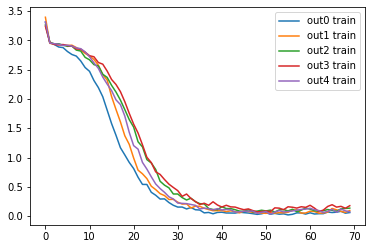

In [1013]:
import matplotlib.pyplot as plt

plt.plot(history.history['out0_loss'], label = 'out0 train')
plt.plot(history.history['out1_loss'], label = 'out1 train')
plt.plot(history.history['out2_loss'], label = 'out2 train')
plt.plot(history.history['out3_loss'], label = 'out3 train')
plt.plot(history.history['out4_loss'], label = 'out4 train')
plt.legend()
plt.show()

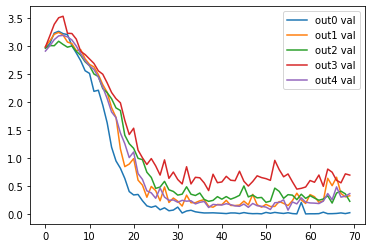

In [1014]:
plt.plot(history.history['val_out0_loss'], label = 'out0 val')
plt.plot(history.history['val_out1_loss'], label = 'out1 val')
plt.plot(history.history['val_out2_loss'], label = 'out2 val')
plt.plot(history.history['val_out3_loss'], label = 'out3 val')
plt.plot(history.history['val_out4_loss'], label = 'out4 val')
plt.legend()
plt.show()

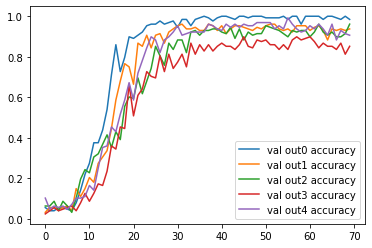

In [1015]:
for i in range(0, 5):
  plt.plot(history.history[f'val_out{i}_accuracy'], label = f'val out{i} accuracy')
plt.legend()
plt.show()

In [1016]:
test_set = generate_batch(test_data, len(test_data), shuffle = False)
model.evaluate(test_set, steps = 1)

1/1 [==============================] - 0s 53ms/step - loss: 1.8721 - out0_loss: 0.0429 - out1_loss: 0.2211 - out2_loss: 0.4328 - out3_loss: 0.7133 - out4_loss: 0.4620 - out0_accuracy: 0.9907 - out1_accuracy: 0.9439 - out2_accuracy: 0.9065 - out3_accuracy: 0.8972 - out4_accuracy: 0.9065


[1.8720704317092896,
 0.04285576194524765,
 0.22110308706760406,
 0.43277600407600403,
 0.7133079171180725,
 0.46202778816223145,
 0.9906542301177979,
 0.9439252614974976,
 0.9065420627593994,
 0.8971962332725525,
 0.9065420627593994]

**It seems we can reach more than 90% accuracy for each digit with this network in test set.**

Now, lets try a more complicated architecture if can get even better results. I use ResNet50 for this purpose.

To start, we need a class to represent ResNet blocks:

In [1017]:
import tensorflow.keras as tfk
from typing import Tuple, List

class ResNetBlock(tfk.layers.Layer):
  '''
    A layer for representing a single block of ResNet50. \n
    It contains a shortcut connection that is added to the output of the main path. \n
    CONV 1*1 -> BN -> RELU -> CONV 3*3 -> BN -> RELU -> CONV 1*1 -> BN -> ADD -> RELU
  '''
  def __init__(self, kernel_size: Tuple[int, int], filters: List[int], reduce: bool, strides: Tuple[int, int] = (1, 1)):
    '''
      Creates a layer for representing a single block of ResNet50.
      :param kernel_size Tuple[int, int]: kernel size of the convolutional layers
      :param filters List[int]: number of filters in the convolutional layers
      :param reduce bool: whether to reduce the size of the input or not
      :param strides Tuple[int, int]: stride of the convolutional layers default (1,1)
    '''
    super(ResNetBlock, self).__init__()
    self.reduce = reduce
    if len(filters) != 3:
      raise ValueError('filters must be a list containing 3 integer numbers.')
    f1, f2, f3 = filters
    # shortcut path
    self.shortcut_conv = tfk.layers.Conv2D(f3, (1, 1), strides = strides, padding = 'valid') if reduce else None
    self.shortcut_bn = tfk.layers.BatchNormalization(axis = 3) if reduce else None
    self.shortcut_activation = tfk.layers.Activation('relu') if reduce else None
    # main path 1 * 1 - batch norm - relu
    self.main_conv1 = tfk.layers.Conv2D(f1, (1, 1), strides = strides, padding = 'valid')
    self.main_bn1 = tfk.layers.BatchNormalization(axis = 3)
    self.main_activation1 = tfk.layers.Activation('relu')
    # main path 3 * 3 - batch norm - relu
    self.main_conv2 = tfk.layers.Conv2D(f2, kernel_size, strides = (1, 1), padding = 'same')
    self.main_bn2 = tfk.layers.BatchNormalization(axis = 3)
    self.main_activation2 = tfk.layers.Activation('relu')
    # main path 1 * 1 - batch norm 
    self.main_conv3 = tfk.layers.Conv2D(f3, (1, 1), strides = (1, 1), padding = 'valid')
    self.main_bn3 = tfk.layers.BatchNormalization(axis = 3)
  
  def call(self, inputs, training = False):
    '''Performs a forward pass through the layer.'''
    shortcut_path = inputs
    # create shortcut filter if needed
    if self.reduce:
      shortcut_path = self.shortcut_conv(shortcut_path, training = training)
      shortcut_path = self.shortcut_bn(shortcut_path, training = training)
      shortcut_path = self.shortcut_activation(shortcut_path, training = training)
    # main path 1 * 1 - batch norm - relu
    main_path = self.main_conv1(inputs, training = training)
    main_path = self.main_bn1(main_path, training = training)
    main_path = self.main_activation1(main_path, training = training)
    # main path 3 * 3 - batch norm - relu
    main_path = self.main_conv2(main_path, training = training)
    main_path = self.main_bn2(main_path, training = training)
    main_path = self.main_activation2(main_path, training = training)
    # main path 1 * 1 - batch norm - relu
    main_path = self.main_conv3(main_path, training = training)
    main_path = self.main_bn3(main_path, training = training)
    # add shortcut path to main path
    result = tfk.layers.Add()([main_path, shortcut_path])
    result = tfk.layers.Activation('relu')(result, training = training)
    return result

Now we can create our ResNet model:

In [1018]:
class ResNetBuilder():
  '''
    A class to represent ResNet50 model. \n
    It contains 16 ResNet blocks. \n
    more details on : https://iq.opengenus.org/resnet50-architecture/
  '''
  def __init__(self):
    '''Creates a ResNet50 model.'''
    # layers we need:
    # before ResNet blocks
    self.conv7_7 = tfk.layers.Conv2D(64, (7,7), strides = (2, 2))
    self.bn1 = tfk.layers.BatchNormalization(axis = 3)
    self.activation1 = tfk.layers.Activation('relu')
    self.max_pool = tfk.layers.MaxPool2D(pool_size = (3,3), strides = (2, 2))
    # first blocks
    self.res_block11 = ResNetBlock((3,3), [64, 64, 256], True, strides = (1, 1))
    self.res_block12 = ResNetBlock((3,3), [64, 64, 256], False)
    self.res_block13 = ResNetBlock((3,3), [64, 64, 256], False)
    # second blocks
    self.res_block21 = ResNetBlock((3,3), [128, 128, 512], True, strides = (2, 2))
    self.res_block22 = ResNetBlock((3,3), [128, 128, 512], False)
    self.res_block23 = ResNetBlock((3,3), [128, 128, 512], False)
    self.res_block24 = ResNetBlock((3,3), [128, 128, 512], False)
    # third blocks
    self.res_block31 = ResNetBlock((3,3), [256, 256, 1024], True, strides = (2, 2))
    self.res_block32 = ResNetBlock((3,3), [256, 256, 1024], False)
    self.res_block33 = ResNetBlock((3,3), [256, 256, 1024], False)
    self.res_block34 = ResNetBlock((3,3), [256, 256, 1024], False)
    self.res_block35 = ResNetBlock((3,3), [256, 256, 1024], False)
    self.res_block36 = ResNetBlock((3,3), [256, 256, 1024], False)
    # fourth blocks
    self.res_block41 = ResNetBlock((3,3), [512, 512, 2048], True, strides = (2, 2))
    self.res_block42 = ResNetBlock((3,3), [512, 512, 2048], False)
    self.res_block43 = ResNetBlock((3,3), [512, 512, 2048], False)
    # averege pool
    self.avg_pool = tfk.layers.AveragePooling2D((1, 1))
    # flatten
    self.flatten = tfk.layers.Flatten()
    self.branches = [FCBlock(f'out{i}', first_layer_units = 128) for i in range(5)]
 
  def get_model(self, input_shape = (50, 200, 1)):
    '''
      Creates a ResNet50 model. \n
      :param input_shape Tuple[int, int, int]: shape of the input. default (50, 200, 1) \n
      :return tfk.Model: the model
    '''
    inputs = tfk.Input(shape=input_shape)  
    # before ResNet blocks
    x = self.conv7_7(inputs)
    x = self.bn1(x)
    x = self.activation1(x)
    x = self.max_pool(x)
    # first blocks
    x = self.res_block11(x)
    x = self.res_block12(x)
    x = self.res_block13(x)
    # second blocks
    x = self.res_block21(x)
    x = self.res_block22(x)
    x = self.res_block23(x)
    x = self.res_block24(x)
    # third blocks
    x = self.res_block31(x)
    x = self.res_block32(x)
    x = self.res_block33(x)
    x = self.res_block34(x)
    x = self.res_block35(x)
    x = self.res_block36(x)
    # fourth blocks
    x = self.res_block41(x)
    x = self.res_block42(x)
    x = self.res_block43(x)
    # avg pooling
    x = self.avg_pool(x)
    # flatten
    x = self.flatten(x)
    # branches
    outputs = []
    for branch in self.branches:
      outputs.append(branch(x))
    return tfk.Model(inputs = inputs, outputs = outputs, name = 'ResNetModel')


Model: "ResNetModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_76 (InputLayer)          [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_3456 (Conv2D)           (None, 22, 97, 64)   3200        ['input_76[0][0]']               
                                                                                                  
 batch_normalization_3383 (Batc  (None, 22, 97, 64)  256         ['conv2d_3456[0][0]']            
 hNormalization)                                                                                  
                                                                                        

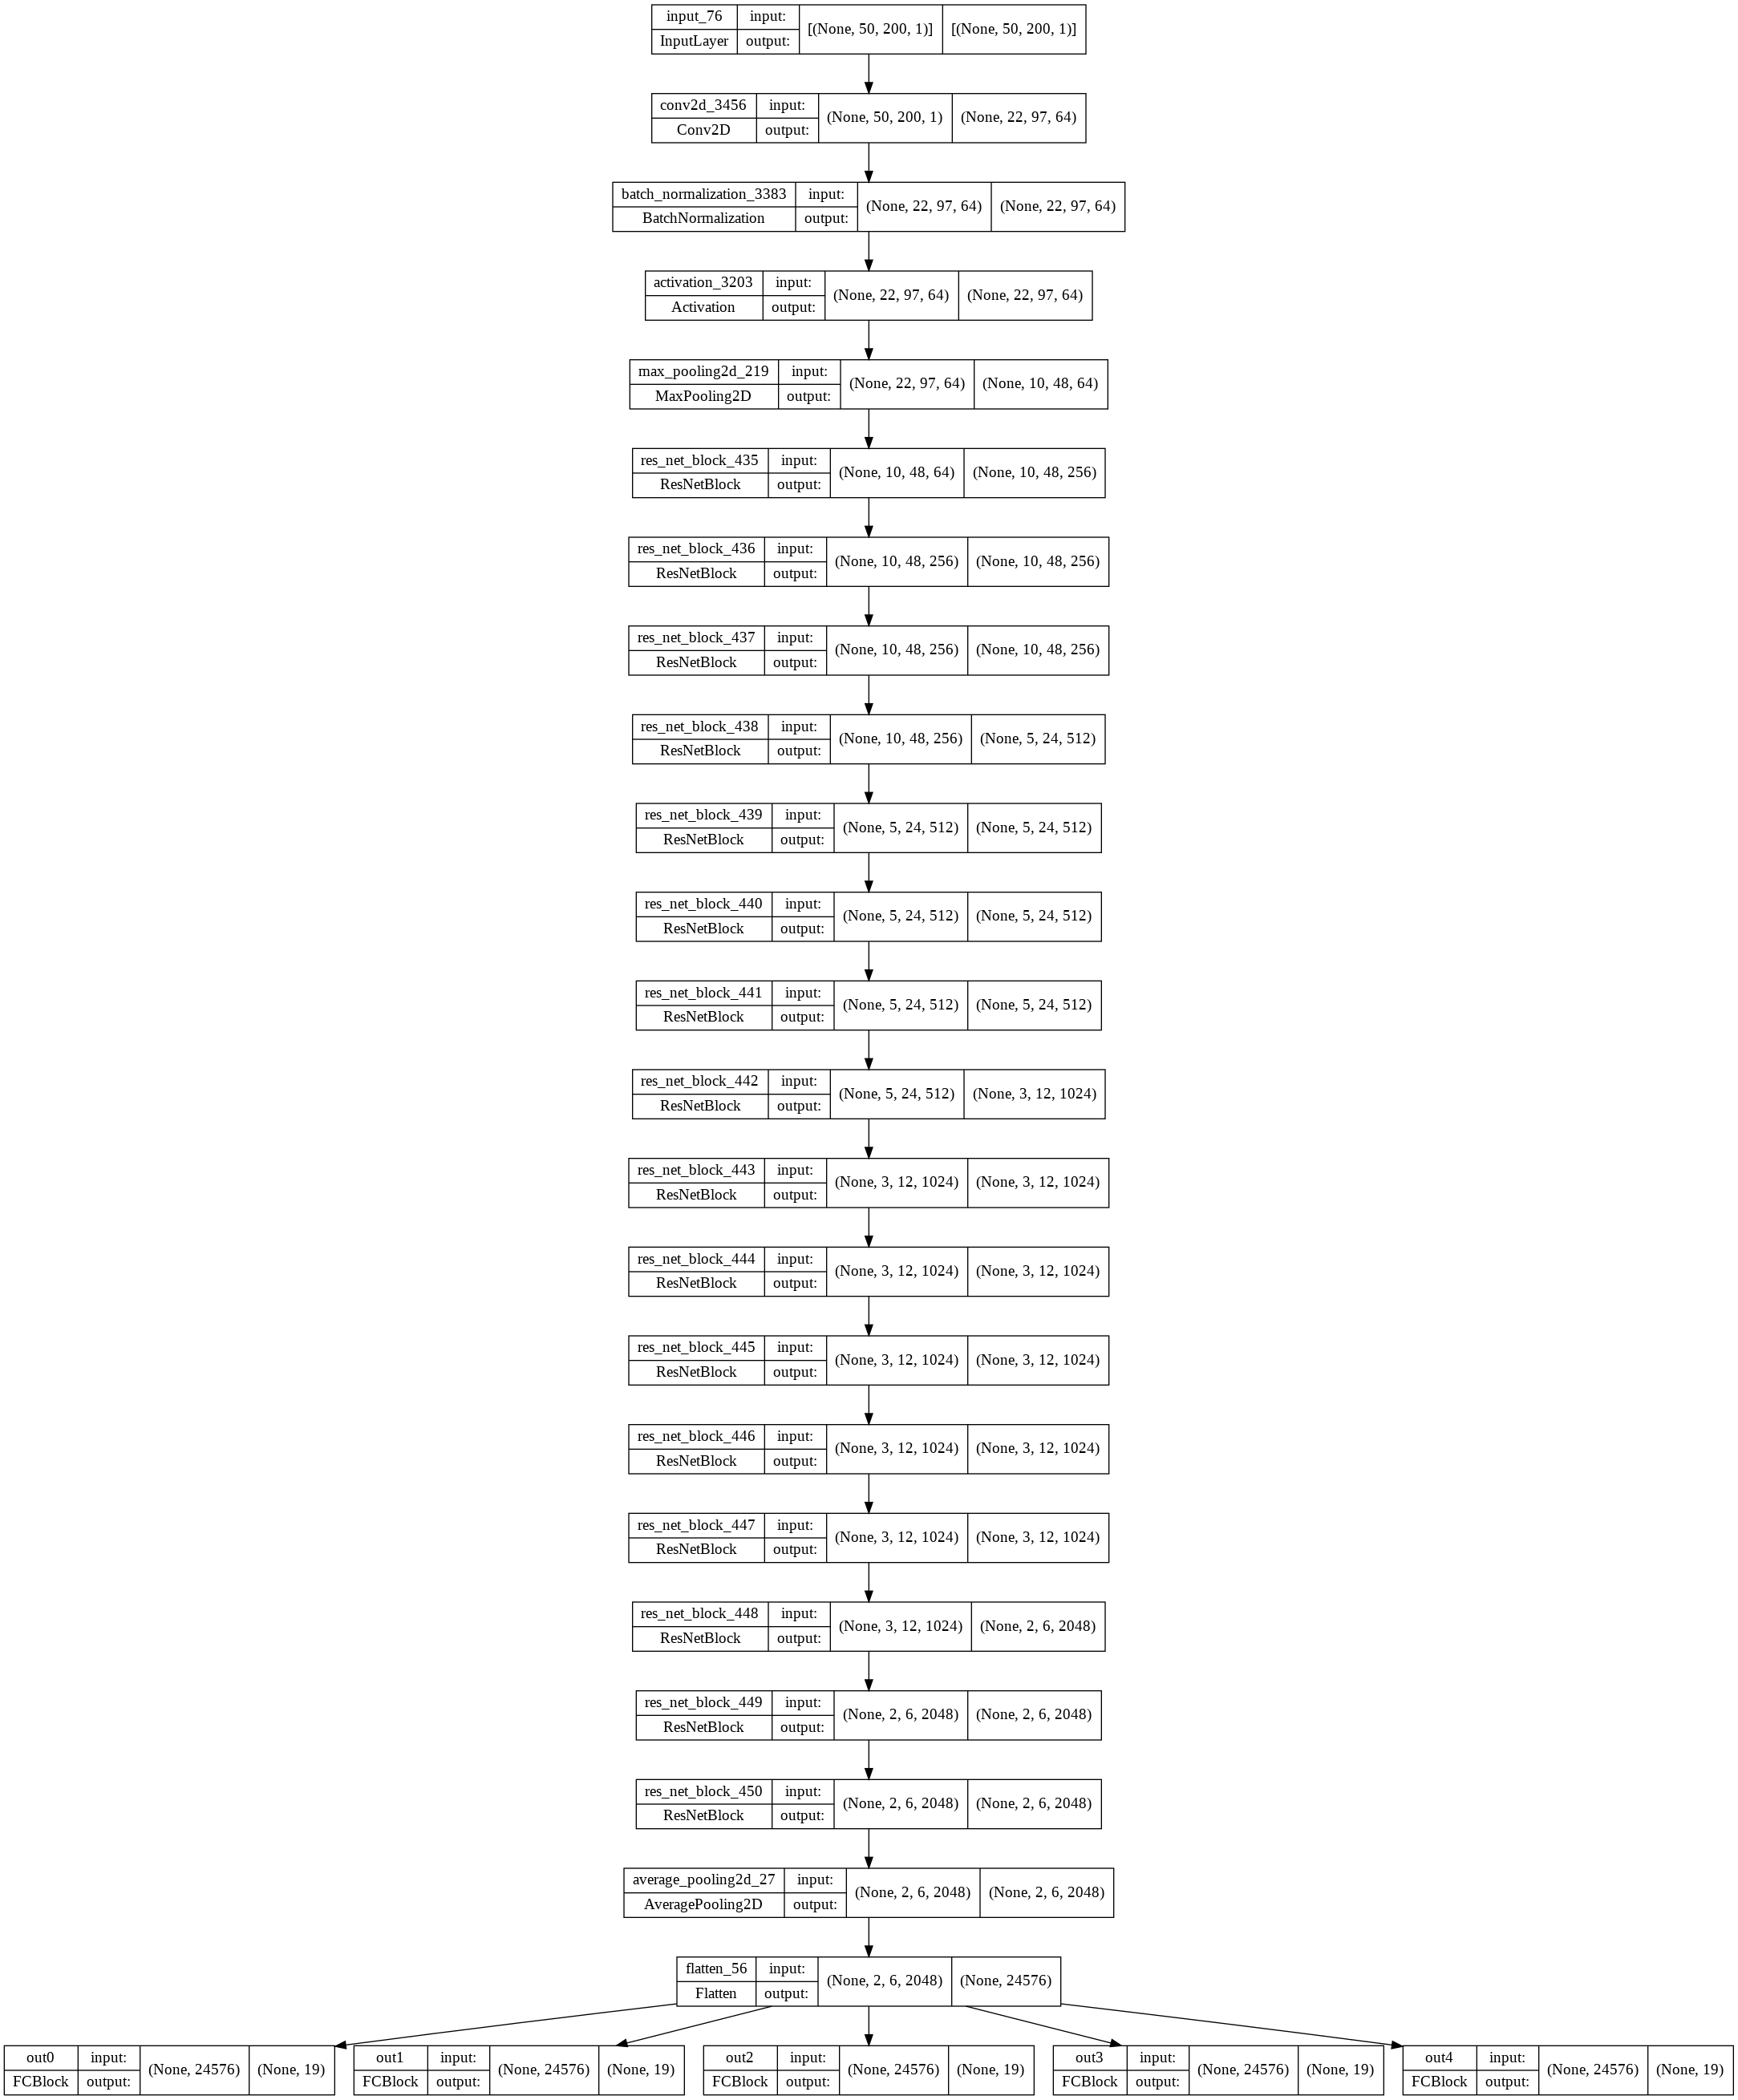

In [1019]:
builder = ResNetBuilder()
model = builder.get_model(input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model.summary()
tfk.utils.plot_model(model, 'resnet.png', show_shapes=True)

In [1020]:
model.compile(
    optimizer = tfk.optimizers.SGD(learning_rate = 0.001),
    loss = {
        'out0': tfk.losses.CategoricalCrossentropy(),
        'out1': tfk.losses.CategoricalCrossentropy(),
        'out2': tfk.losses.CategoricalCrossentropy(),
        'out3': tfk.losses.CategoricalCrossentropy(),
        'out4': tfk.losses.CategoricalCrossentropy()
    },
    metrics = {
        'out0': 'accuracy',
        'out1': 'accuracy',
        'out2': 'accuracy',
        'out3': 'accuracy',
        'out4': 'accuracy',
    }
)

In [1021]:
train_gen = generate_batch(train_data)
val_gen = generate_batch(val_data)
batch_size = 32
history = model.fit(
    x = train_gen,
    validation_data = val_gen,
    epochs = 100,
    batch_size = batch_size,
    steps_per_epoch = len(train_data) // batch_size + 1,
    validation_steps = len(val_data) // batch_size + 1,
    callbacks = [AdaptiveSchedulerCallback()]
)

Epoch 1/100
27/27 [==============================] - 13s 299ms/step - loss: 17.1073 - out0_loss: 3.3997 - out1_loss: 3.5095 - out2_loss: 3.4261 - out3_loss: 3.4072 - out4_loss: 3.3648 - out0_accuracy: 0.0706 - out1_accuracy: 0.0521 - out2_accuracy: 0.0567 - out3_accuracy: 0.0579 - out4_accuracy: 0.0845 - val_loss: 14.7355 - val_out0_loss: 2.9578 - val_out1_loss: 2.9387 - val_out2_loss: 2.9487 - val_out3_loss: 2.9449 - val_out4_loss: 2.9453 - val_out0_accuracy: 0.0312 - val_out1_accuracy: 0.0703 - val_out2_accuracy: 0.0469 - val_out3_accuracy: 0.0391 - val_out4_accuracy: 0.0234
Epoch 2/100
27/27 [==============================] - 10s 393ms/step - loss: 14.8347 - out0_loss: 2.9766 - out1_loss: 2.9697 - out2_loss: 2.9763 - out3_loss: 2.9838 - out4_loss: 2.9283 - out0_accuracy: 0.0660 - out1_accuracy: 0.0706 - out2_accuracy: 0.0590 - out3_accuracy: 0.0613 - out4_accuracy: 0.0914 - val_loss: 14.7263 - val_out0_loss: 2.9392 - val_out1_loss: 2.9518 - val_out2_loss: 2.9361 - val_out3_loss: 2.9

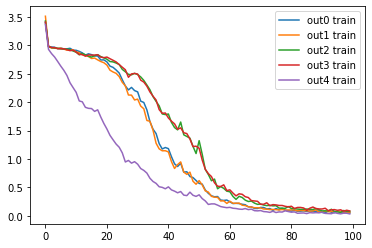

In [1022]:
import matplotlib.pyplot as plt

plt.plot(history.history['out0_loss'], label = 'out0 train')
plt.plot(history.history['out1_loss'], label = 'out1 train')
plt.plot(history.history['out2_loss'], label = 'out2 train')
plt.plot(history.history['out3_loss'], label = 'out3 train')
plt.plot(history.history['out4_loss'], label = 'out4 train')
plt.legend()
plt.show()

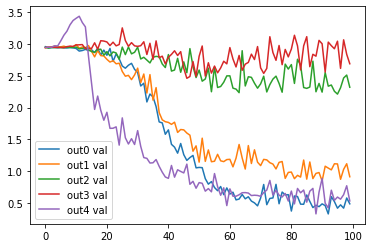

In [1023]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_out0_loss'], label = 'out0 val')
plt.plot(history.history['val_out1_loss'], label = 'out1 val')
plt.plot(history.history['val_out2_loss'], label = 'out2 val')
plt.plot(history.history['val_out3_loss'], label = 'out3 val')
plt.plot(history.history['val_out4_loss'], label = 'out4 val')
plt.legend()
plt.show()

**Unfortunately I couldn't find a good hyperparameter combination for ResNet50 and the result is not good.**

Another model is DFCR which is a type of DenseNet. 
I used this [link](https://www.aimspress.com/fileOther/PDF/MBE/mbe-16-05-292.pdf) to implement the architecture.

firstly, we create a layer to represent the following layers:  
BN -> ReLU -> CONV

In [1024]:
class BatchReluConv(tfk.layers.Layer):
  '''
    A layer containg a batch normalization, a relu activation, and a convolutional layer. \n
    It is used in dense block in DenseNet. \n
    BN -> RELU -> CONV
  '''
  def __init__(self, kernels: int, conv_kernel: Tuple[int, int]):
    '''
      Creates a layer containg a batch normalization, a relu activation, and a convolutional layer.
      :param kernels int: number of kernels in the convolutional layer
      :param conv_kernel Tuple[int, int]: kernel size of the convolutional layer
    '''
    super(BatchReluConv, self).__init__()
    self.bn = tfk.layers.BatchNormalization(axis = 3)
    self.relu = tfk.layers.Activation('relu')
    self.conv = tfk.layers.Conv2D(kernels, conv_kernel, strides = (1, 1), padding = 'same')

  def call(self, x, training = False):
    '''Performs a forward pass through the layer.'''
    x = self.bn(x, training = training)
    x = self.relu(x, training = training)
    x = self.conv(x, training = training)
    return x

Next we create our transition layer which is something like this:  
BN -> ReLU -> CONV -> POOL

In [1025]:
class Transition(tfk.layers.Layer):
  '''
    A layer for representing a transition block in DenseNet(DFCR Version). \n
    It is used to reduce the size of the input. \n
    BN -> ReLU -> CONV 1*1 -> AVGPOOL 2*2 \n
  '''
  def __init__(self, kernels: int, conv_kernel: Tuple[int, int] = (1, 1), conv_strides: Tuple[int, int] = (1, 1),
               pool_kernel: Tuple[int, int] = (2, 2), pool_strides: Tuple[int, int] = (2, 2)):
    '''
      Creates a layer for representing a transition block in DenseNet.
      :param kernels int: number of kernels in the convolutional layer
      :param conv_kernel Tuple[int, int]: kernel size of the convolutional layer
      :param conv_strides Tuple[int, int]: stride of the convolutional layer
      :param pool_kernel Tuple[int, int]: kernel size of the average pooling layer
      :param pool_strides Tuple[int, int]: stride of the average pooling layer
    '''
    super(Transition, self).__init__()
    self.bn = tfk.layers.BatchNormalization(axis = 3)
    self.relu = tfk.layers.Activation('relu')
    self.conv = tfk.layers.Conv2D(kernels, conv_kernel, strides = conv_strides, padding = 'valid')
    self.pool = tfk.layers.MaxPool2D(pool_kernel, strides = pool_strides, padding = 'valid')
  
  def call(self, x, training = False):
    '''Performs a forward pass through the layer.'''
    x = self.bn(x)
    x = self.relu(x)
    x = self.conv(x, training = training)
    x = self.pool(x, training = training)
    return x

Now we can create our dense block. In dense blocks every feature map in is connected to every other feature maps in the same block.
Each feature map is concatenated with its previous feature maps.  
between each two feature map we have:  
BN -> RELU -> CONV 1×1 -> BN -> RELU -> CONV 3×3

In [1026]:
class DFCRDenseBlock(tfk.layers.Layer):
  ''''
    Represents a dense block in DenseNet(DFCR Version).
    Every feature map in this block is connected to every other feature map in the same block.
    Each feature map is concatenated with its previous feature maps.
    between each two feature map we have:
    BN -> RELU -> CONV 1*1 -> BN -> RELU -> CONV 3*3
  '''
  def __init__(self, l: int, k: int):
    '''
      Creates a dense block in DenseNet(DFCR Version).
      :param l int: number of layers in the block
      :param k int: growth rate of the block. its the depth of the output feature maps.
    '''
    super(DFCRDenseBlock, self).__init__()
    self.l = l
    self.k = k
    self.brc_list = [(BatchReluConv(4 * k, (1, 1)), BatchReluConv(k, (3, 3))) for _ in range(l - 1)]

  def call(self, x, training = False):
    '''Performs a forward pass through the layer.'''
    last_layer = x
    last_concat = x
    for i in range(self.l - 1):
      new_layer = self.brc_list[i][0](last_layer, training = training)
      new_layer = self.brc_list[i][1](new_layer, training = training)
      last_layer = new_layer
      last_concat = tfk.layers.Concatenate()([last_concat, new_layer])
    return last_concat


finally, we can create our model:

In [1027]:
class DFCRBuilder:
  def __init__(self, k: int = 32, theta: float = 0.5, block_sizes: List[int] = [6, 6, 24, 16]):
    # initial 7*7 conv with strides (2, 2) and 3*3 max pool with strides (2, 2)
    self.init_pad1 = tfk.layers.ZeroPadding2D(padding = (3, 3))
    self.init_conv = tfk.layers.Conv2D(2 * k, (7, 7), strides = (2, 2), padding = 'valid')
    self.init_pad2 = tfk.layers.ZeroPadding2D(padding = (1, 1))
    self.init_pool = tfk.layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid')
    current_channels = 2 * k
    # dense1 + 1 * 1 conv + 2*2 average pool with strides (2, 2)
    self.dense1 = DFCRDenseBlock(block_sizes[0], k)
    current_channels = current_channels + (block_sizes[0] - 1) * k
    self.transition1 = Transition(int(current_channels * theta))
    current_channels = int(current_channels * theta)
    # dense2 + 1 * 1 conv + 2*2 average pool with strides (2, 2)
    self.dense2 = DFCRDenseBlock(block_sizes[1], k)
    current_channels = current_channels + (block_sizes[1] - 1) * k
    self.transition2 = Transition(int(current_channels * theta))
    current_channels = int(current_channels * theta)
    # dense3 + 1 * 1 conv + 2*2 average pool with strides (2, 2)
    self.dense3 = DFCRDenseBlock(block_sizes[2], k)
    current_channels = current_channels + (block_sizes[2] - 1) * k
    self.transition3 = Transition(int(current_channels * theta))
    current_channels = int(current_channels * theta)
    # dense4
    self.dense4 = DFCRDenseBlock(block_sizes[3], k)
    # global average pooling
    self.global_pool = tfk.layers.GlobalAveragePooling2D()
    # output branches
    self.branches = [FCBlock(f'out{i}', first_layer = True, dropout = True, first_layer_units = 128) for i in range(5)]

  def get_model(self, input_shape = (64, 256, 1)):
    inputs = tfk.Input(input_shape)  
    x = self.init_pad1(inputs)
    x = self.init_conv(x)
    x = self.init_pad2(x)
    x = self.init_pool(x)
    x = self.dense1(x)
    x = self.transition1(x)
    x = self.dense2(x)
    x = self.transition2(x)
    x = self.dense3(x)
    x = self.transition3(x)
    x = self.dense4(x)
    x = self.global_pool(x)
    # output branches
    outputs = []
    for branch in self.branches:
      outputs.append(branch(x))
    return tfk.Model(inputs = inputs, outputs = outputs, name = 'DFCRModel')
  

Model: "DFCRModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_77 (InputLayer)          [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d_38 (ZeroPadding  (None, 56, 206, 1)  0           ['input_77[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv2d_3509 (Conv2D)           (None, 25, 100, 64)  3200        ['zero_padding2d_38[0][0]']      
                                                                                          

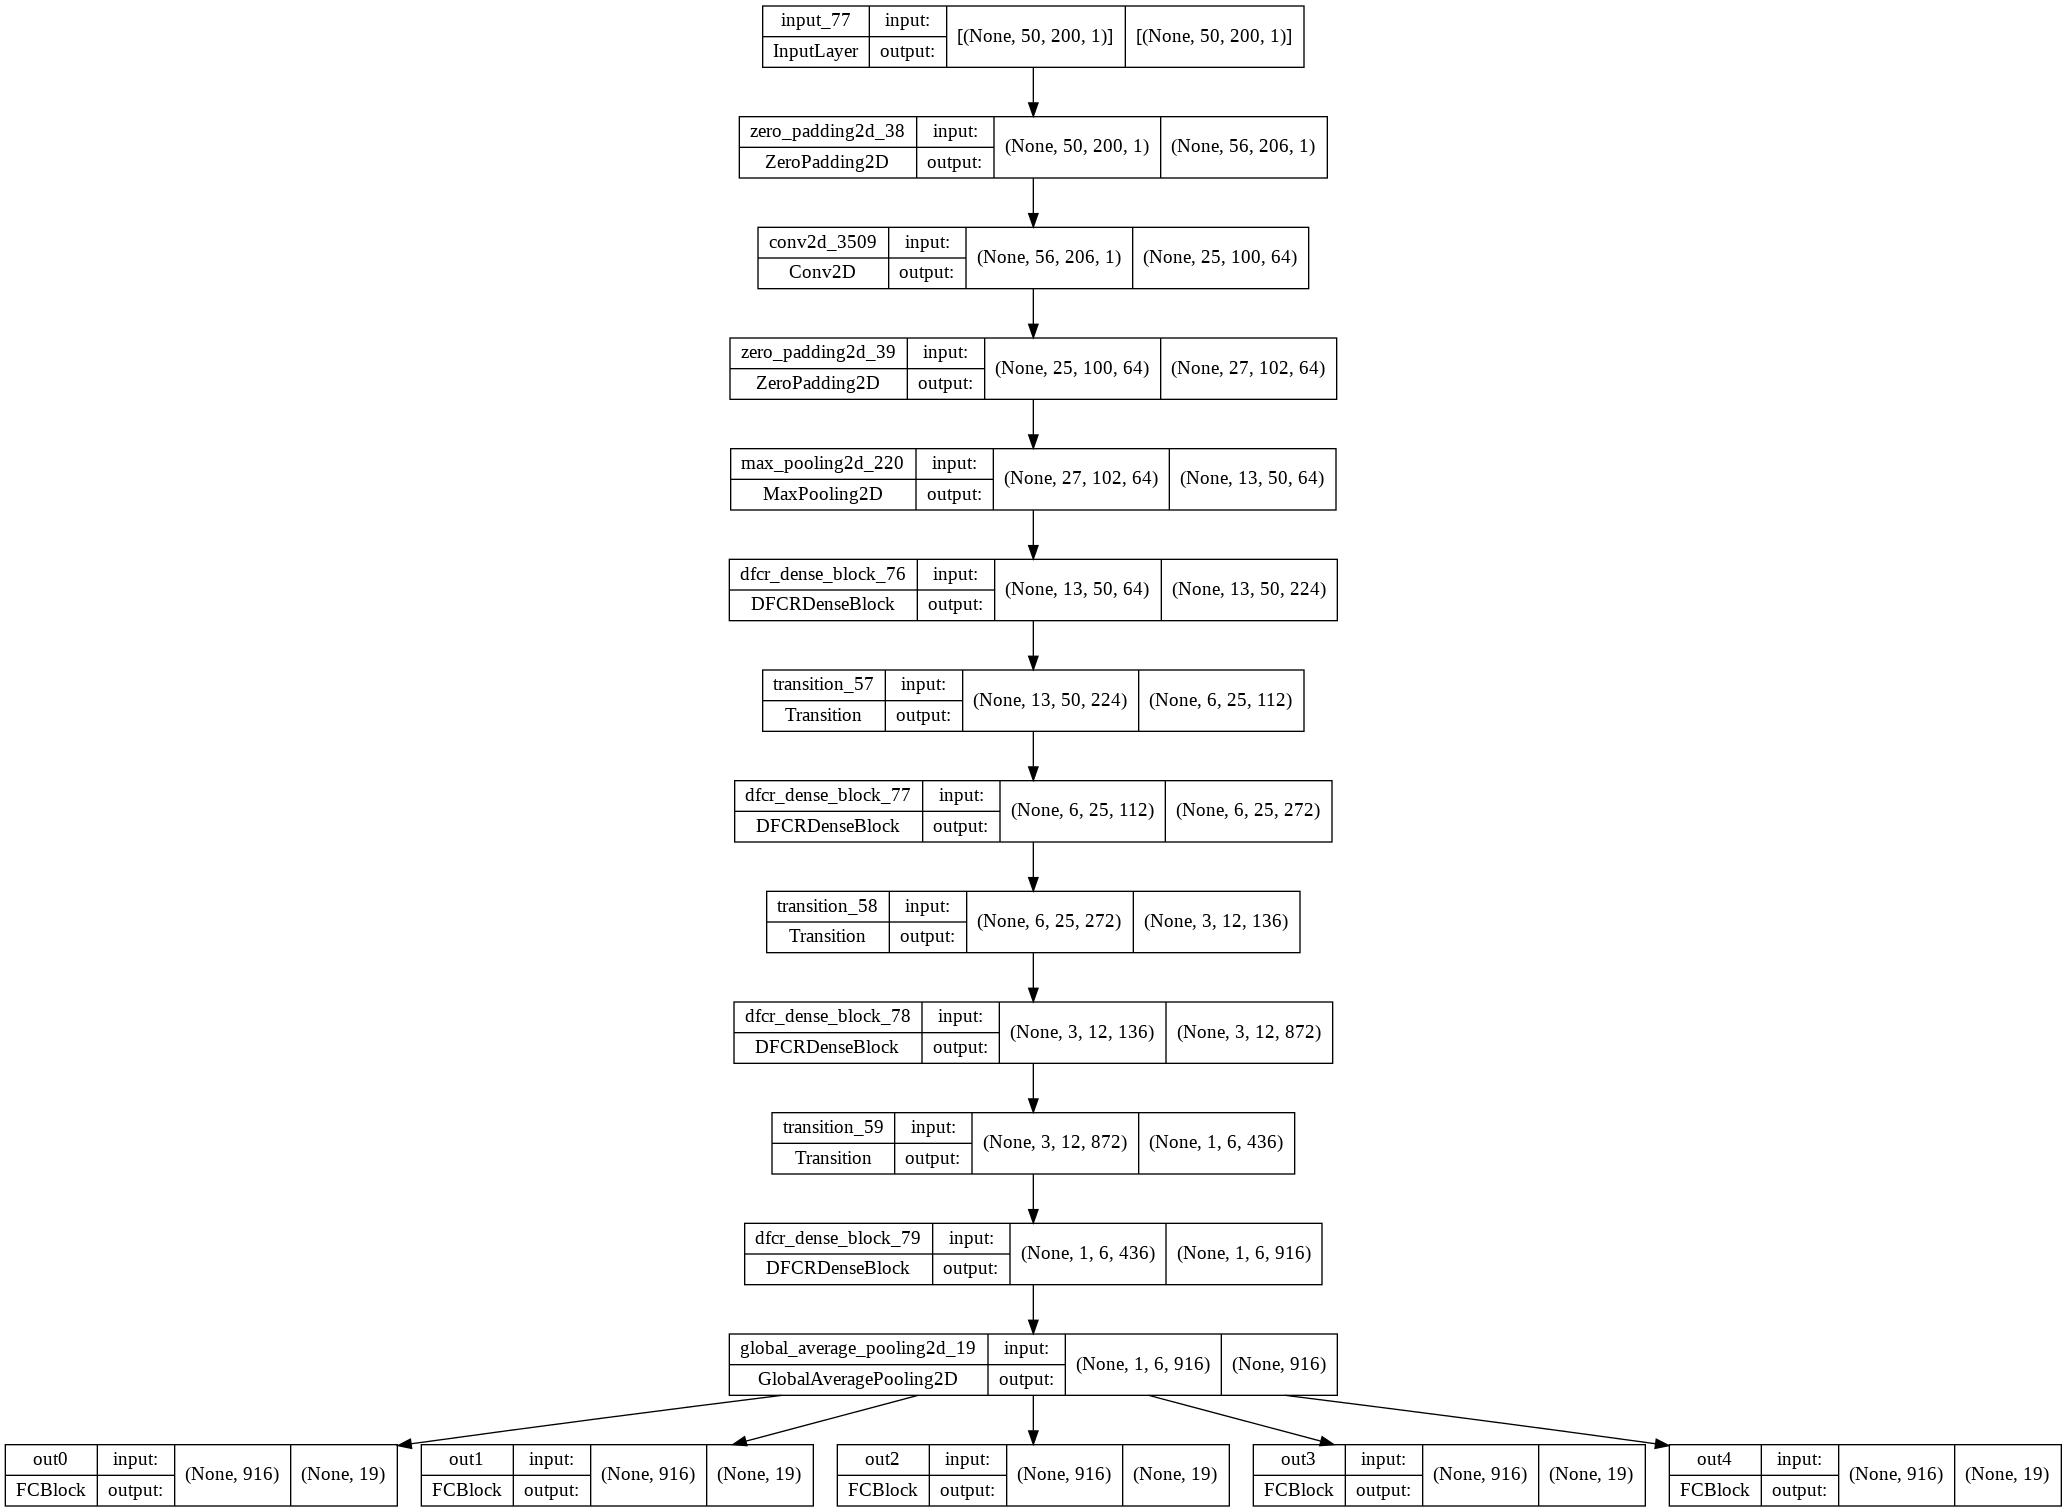

In [1028]:
builder = DFCRBuilder()
model = builder.get_model(input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model.summary()
tfk.utils.plot_model(model, 'DFCR.png', show_shapes=True, expand_nested = True)

we can use a step decay scheduler:

In [1029]:
def step_decay_scheduler(epoch: int, lr: int, alpha0: float = 0.001, k: float = 0.5, thresh: int = 20):
  '''
  Calculates the next learning rate value formula: lr = alpha0 * k ^ (epoch // thresh)
  :param epoch: index of the current epoch starting from 0
  :param lr: current learning rate value
  :param alpha0: the initial learning rate
  :param k: decay coefficient. the lr value devides by this number every $num_epochs epochs.
  :param num_epochs: number of consecutive epochs in which the lr is constant.
  '''
  return alpha0 * (k ** (epoch // thresh))

In [1030]:
model.compile(
    optimizer = tfk.optimizers.SGD(learning_rate = 0.001),
    loss = {
        'out0': tfk.losses.CategoricalCrossentropy(),
        'out1': tfk.losses.CategoricalCrossentropy(),
        'out2': tfk.losses.CategoricalCrossentropy(),
        'out3': tfk.losses.CategoricalCrossentropy(),
        'out4': tfk.losses.CategoricalCrossentropy()
    },
    metrics = {
        'out0': 'accuracy',
        'out1': 'accuracy',
        'out2': 'accuracy',
        'out3': 'accuracy',
        'out4': 'accuracy',
    }
)

In [1031]:
train_gen = generate_batch(train_data)
val_gen = generate_batch(val_data)
batch_size = 64
history = model.fit(
    x = train_gen,
    validation_data = val_gen,
    epochs = 150,
    batch_size = batch_size,
    steps_per_epoch = len(train_data) // batch_size + 1,
    validation_steps = len(val_data) // batch_size + 1,
    callbacks = [tfk.callbacks.LearningRateScheduler(step_decay_scheduler)]
)

Epoch 1/150
14/14 [==============================] - 14s 300ms/step - loss: 15.9238 - out0_loss: 3.1906 - out1_loss: 3.1067 - out2_loss: 3.1970 - out3_loss: 3.2065 - out4_loss: 3.2229 - out0_accuracy: 0.0513 - out1_accuracy: 0.0469 - out2_accuracy: 0.0603 - out3_accuracy: 0.0714 - out4_accuracy: 0.0424 - val_loss: 423909904860839936.0000 - val_out0_loss: 90833636277878784.0000 - val_out1_loss: 82851551227412480.0000 - val_out2_loss: 76191233772355584.0000 - val_out3_loss: 55477633000931328.0000 - val_out4_loss: 118555837697359872.0000 - val_out0_accuracy: 0.0469 - val_out1_accuracy: 0.0312 - val_out2_accuracy: 0.0469 - val_out3_accuracy: 0.0625 - val_out4_accuracy: 0.1406 - lr: 0.0010
Epoch 2/150
14/14 [==============================] - 7s 534ms/step - loss: 15.8278 - out0_loss: 3.1168 - out1_loss: 3.0739 - out2_loss: 3.1976 - out3_loss: 3.2734 - out4_loss: 3.1662 - out0_accuracy: 0.0513 - out1_accuracy: 0.0513 - out2_accuracy: 0.0469 - out3_accuracy: 0.0491 - out4_accuracy: 0.0603 - v

Unfortunately I haven't find a good hyperparameter for this network. :(

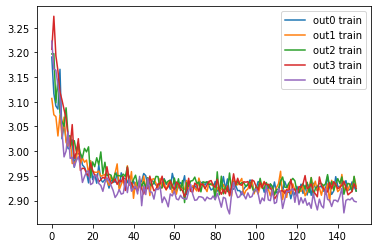

In [1032]:
import matplotlib.pyplot as plt

plt.plot(history.history['out0_loss'], label = 'out0 train')
plt.plot(history.history['out1_loss'], label = 'out1 train')
plt.plot(history.history['out2_loss'], label = 'out2 train')
plt.plot(history.history['out3_loss'], label = 'out3 train')
plt.plot(history.history['out4_loss'], label = 'out4 train')
plt.legend()
plt.show()

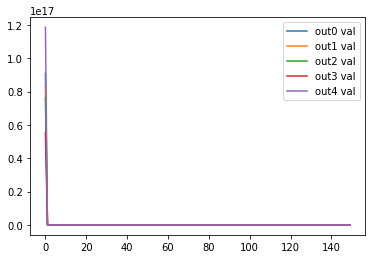

In [1033]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_out0_loss'], label = 'out0 val')
plt.plot(history.history['val_out1_loss'], label = 'out1 val')
plt.plot(history.history['val_out2_loss'], label = 'out2 val')
plt.plot(history.history['val_out3_loss'], label = 'out3 val')
plt.plot(history.history['val_out4_loss'], label = 'out4 val')
plt.legend()
plt.show()